<a href="https://colab.research.google.com/github/BitUpTeam/BitUp/blob/Amasya/TimeSeries_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Временные ряды

* ~удалить ненужные комментарии~
* ~сделать цикл для подбора альфа в экспоненциальном сглаживании~
* попробовать экспоненциальное сглаживание и для других параметров
* Доделать SARIMAX:
  * Подобрать внешние параметры (цикл или grid)
  * Разобраться что делать с экзогенными факторами
  * Привести в человеческий вид

## Доказательство random walk

[Статья](https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/)

> A random walk is one in which future steps or directions cannot be predicted on the basis of past history. When the term is applied to the **stock market**, it means that short-run changes in stock prices are unpredictable.

>Random walk — это такое блуждание, при котором будущие шаги или направления невозможно предсказать на основе прошлой истории. Когда этот термин применяется к **фондовому рынку**, это означает, что краткосрочные изменения цен на акции непредсказуемы.

* The time series shows a strong temporal dependence that decays linearly or in a similar pattern. ✅
* The time series is non-stationary and making it stationary shows no obviously learnable structure in the data. ✅
* The persistence model provides the best source of reliable predictions.

* Временной ряд показывает сильную временную зависимость, которая затухает линейно или аналогично. ✅
* Временной ряд нестационарен, и его стационарность не показывает очевидной обучаемой структуры данных. ✅
* Модель постоянства *(предсказание только по предыдущему значению)* обеспечивает лучший источник надежных прогнозов. (Это я не стал проверять, ибо для этого нужно пробовать различные методы предсказания и показать, что модель постоянства справилась лучше всего)

### Временной ряд показывает сильную временную зависимость, которая затухает линейно или аналогично.

> Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.✅

> Учитывая способ построения random walk, мы ожидаем сильную автокорреляци с предыдущими наблюдениями и линейный спада с значениями запаздывания.✅

*наша автокорреляция*

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

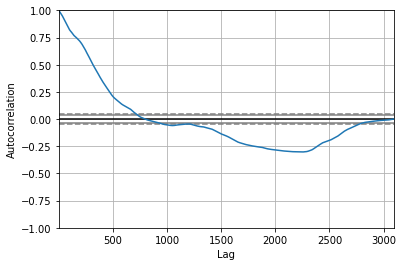

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])

*автокорреляция из статьи*

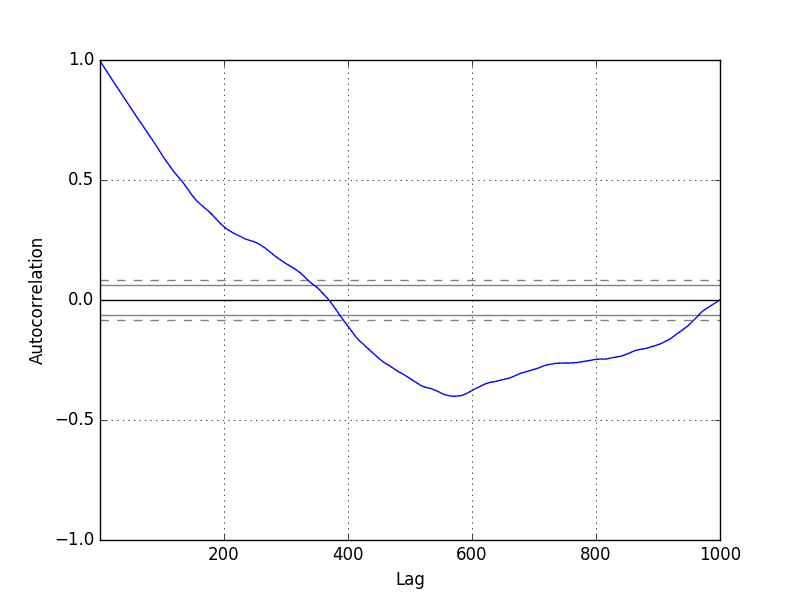

***Видно что повидение графиков совпадает***

Тут хорошо видно сильную автокорреляцию с предыдущими наблюдениями и линейный спад

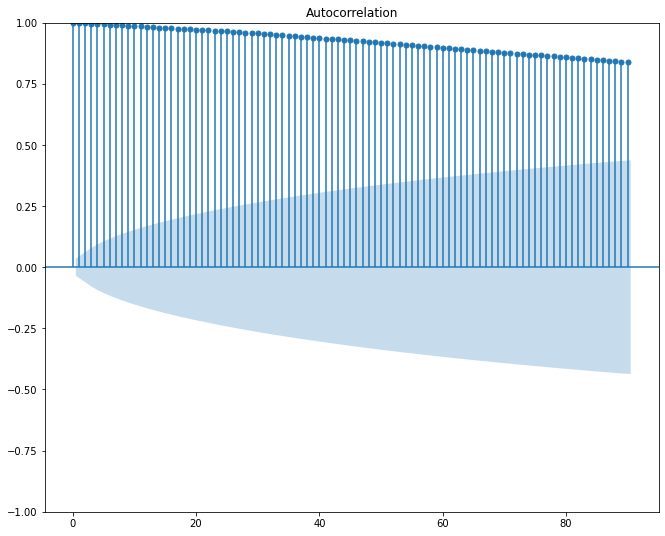

In [ ]:
plot_acf(df['Close'], lags=90)
plt.show()

### Временной ряд нестационарен, и его стационарность не показывает очевидной обучаемой структуры данных.

>The current observation is a random step from the previous observation. Therefore we can expect a random walk to be non-stationary.✅

>Текущее наблюдение представляет собой случайный шаг по сравнению с предыдущим наблюдением. Поэтому мы можем ожидать, что random walk будет нестационарным.✅

Проведем тест Дики-Фуллера, альфа равна 0.05. Если p-value значительно выше этого значения, то нельзя отвергат гипотезу, что процесс нестационарный

In [ ]:
adf_test = adfuller(df['Close'])
print('p-value = ' + str(adf_test[1]))
adf_test[0]

p-value = 0.4763205753527942


-1.613153223585566

*нижнее число - это критическое значение. оно больше табличного значения при нашем альфа, так что гипотезу не отвергаем*

> We can see no significant relationship between the lagged observations, as we would expect from the way the random walk was generated. All correlations are small, close to zero and below the 95% and 99% confidence levels (beyond a few statistical flukes).✅

>Мы не видим существенной связи между запаздывающими наблюдениями, как можно было бы ожидать, исходя из того, как сгенерирован random walk. Все корреляции малы, близки к нулю и ниже уровней достоверности 95% и 99% (за исключением нескольких статистических случайностей).✅

*наше*

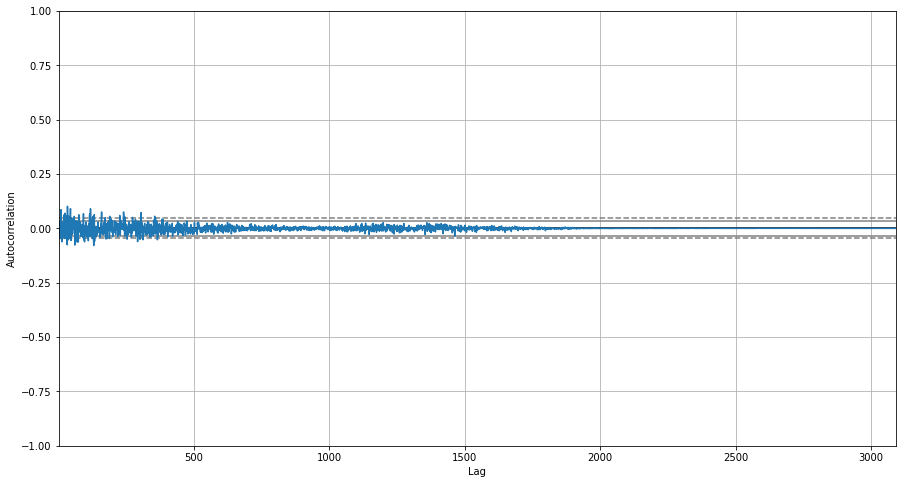

In [ ]:
plt.figure(figsize = (15,8))
autocorrelation_plot(diff)
plt.show()

*статья*

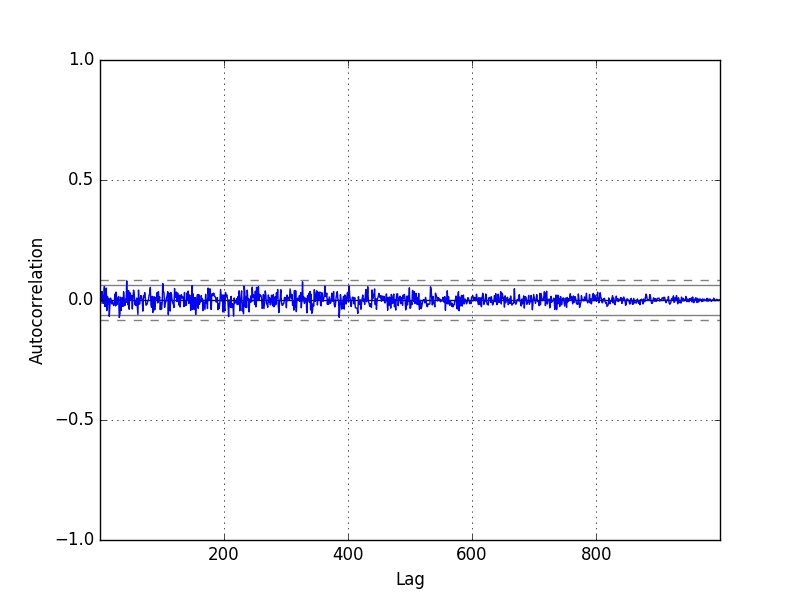

## Анализ датасета как временного ряда

### Подключение библиотек и импорт датасета

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta

In [ ]:
df = pd.read_csv("https://github.com/BitUpTeam/BitUp/blob/main/BTC-USD-DAY-17.09.2014-06.03.2023.csv?raw=true", index_col = 'Date', parse_dates = True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516
2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,22362.679688,26062404610
2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913


### Describe по годам

In [ ]:
df.resample(rule = 'AS').mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,365.058217,373.265397,355.903726,363.693085,363.693085,2.383690e+07
2015-01-01,272.149011,278.151978,266.807891,272.453381,272.453381,3.390557e+07
2016-01-01,567.141429,574.302273,560.453374,568.492407,568.492407,8.592451e+07
2017-01-01,3970.644848,4144.687445,3811.707792,4006.033629,4006.033629,2.382867e+09
2018-01-01,7601.018680,7787.978969,7350.747939,7572.298947,7572.298947,6.063552e+09
2019-01-01,7385.218456,7549.907409,7222.602868,7395.246282,7395.246282,1.673049e+10
2020-01-01,11056.787201,11304.359035,10844.595163,11116.378092,11116.378092,3.302327e+10
2021-01-01,47402.115663,48762.998925,45852.003082,47436.932021,47436.932021,4.715574e+10
2022-01-01,28278.690293,28817.806389,27617.101102,28197.754099,28197.754099,3.001327e+10


In [ ]:
df.resample(rule = 'AS').std()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,31.818564,32.940094,29.587143,30.521741,30.521741,1.497901e+07
2015-01-01,58.736787,61.344046,56.767289,59.337860,59.337860,2.710299e+07
2016-01-01,137.909459,140.461699,135.860573,139.255734,139.255734,5.034484e+07
2017-01-01,4022.608833,4252.932093,3773.187657,4053.192202,4053.192202,3.786476e+09
2018-01-01,2469.977689,2578.010416,2296.187631,2455.455466,2455.455466,3.085421e+09
2019-01-01,2645.219348,2733.163682,2538.099492,2638.635051,2638.635051,7.469125e+09
2020-01-01,4207.018926,4368.070674,4124.057120,4305.858903,4305.858903,1.168510e+10
2021-01-01,9840.860532,9844.917688,9811.253779,9787.634672,9787.634672,2.473559e+10
2022-01-01,10223.219533,10435.335719,9970.726948,10198.035764,10198.035764,1.260659e+10


In [ ]:
df.resample(rule = 'AS').min()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,310.914001,314.808990,289.295990,310.737000,310.737000,5914570
2015-01-01,176.897003,211.731003,171.509995,178.102997,178.102997,7860650
2016-01-01,365.072998,374.950012,354.914001,364.330994,364.330994,28514000
2017-01-01,775.177979,823.307007,755.755981,777.757019,777.757019,60851700
2018-01-01,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2923670016
2019-01-01,3401.376465,3427.945557,3391.023682,3399.471680,3399.471680,4324200990
2020-01-01,5002.578125,5331.833984,4106.980957,4970.788086,4970.788086,12252601475
2021-01-01,28994.009766,29600.626953,28722.755859,29374.152344,29374.152344,18787986667
2022-01-01,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,9744636213


In [ ]:
df.resample(rule = 'AS').quantile(0.25)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,342.700493,351.138496,335.139740,340.218246,340.218246,1.400440e+07
2015-01-01,234.052994,237.697006,231.089005,234.175995,234.175995,1.881530e+07
2016-01-01,431.963990,434.684250,427.193253,432.206756,432.206756,5.633540e+07
2017-01-01,1187.300049,1207.140015,1172.609985,1187.869995,1187.869995,3.326030e+08
2018-01-01,6386.129883,6502.279785,6310.109863,6385.620117,6385.620117,4.159680e+09
2019-01-01,4156.919434,4905.954590,4155.316895,4879.877930,4879.877930,1.089713e+10
2020-01-01,8866.305175,9037.108887,8706.850586,8876.619629,8876.619629,2.405885e+10
2021-01-01,38213.332031,39750.031250,36317.500000,38347.062500,38347.062500,3.237997e+10
2022-01-01,19550.466797,20041.085938,19173.333984,19546.849609,19546.849609,2.241721e+10


In [ ]:
df.resample(rule = 'AS').quantile(0.5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,365.272003,375.547989,356.613998,364.145005,364.145005,1.869935e+07
2015-01-01,248.720993,254.692001,244.126999,249.007004,249.007004,2.478250e+07
2016-01-01,582.071015,588.960998,575.311981,582.555999,582.555999,7.076340e+07
2017-01-01,2577.770020,2682.260010,2510.479980,2589.409912,2589.409912,1.182870e+09
2018-01-01,6919.979980,7109.560059,6747.979980,6906.919922,6906.919922,5.079810e+09
2019-01-01,7826.901367,8047.413086,7583.219727,7824.231445,7824.231445,1.655562e+10
2020-01-01,9695.667969,9852.803223,9543.532715,9713.494629,9713.494629,3.251144e+10
2021-01-01,47810.687500,49202.878906,46671.964844,47783.359375,47783.359375,4.058521e+10
2022-01-01,23179.527344,23563.832031,22722.265625,23164.628906,23164.628906,2.814822e+10


In [ ]:
df.resample(rule = 'AS').quantile(0.75)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,382.910507,391.278496,374.537994,382.772751,382.772751,3.058330e+07
2015-01-01,284.880005,291.114014,281.010986,285.299988,285.299988,4.130240e+07
2016-01-01,663.334000,673.189988,653.622253,664.227020,664.227020,9.517587e+07
2017-01-01,4555.589844,4625.680176,4377.459961,4578.770020,4578.770020,2.219410e+09
2018-01-01,8705.190430,8958.469727,8360.620117,8668.120117,8668.120117,6.925190e+09
2019-01-01,9548.178711,9796.755859,9411.521484,9551.714844,9551.714844,2.124268e+10
2020-01-01,11663.331299,11798.418701,11438.752685,11679.550049,11679.550049,4.084896e+10
2021-01-01,56191.585938,57793.039063,54288.156250,56216.183594,56216.183594,5.823847e+10
2022-01-01,39148.449219,39845.925781,38113.664063,39105.148438,39105.148438,3.442156e+10


In [ ]:
df.resample(rule = 'AS').max()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,465.864014,468.174011,452.421997,457.334015,457.334015,83641104
2015-01-01,465.208008,495.562012,456.765015,465.321014,465.321014,263900000
2016-01-01,975.125000,979.396973,954.502991,975.921021,975.921021,363320992
2017-01-01,19475.800781,20089.000000,18974.099609,19497.400391,19497.400391,22197999616
2018-01-01,17527.300781,17712.400391,16764.599609,17527.000000,17527.000000,23840899072
2019-01-01,13017.125000,13796.489258,12233.261719,13016.231445,13016.231445,45105733173
2020-01-01,28841.574219,29244.876953,28201.992188,29001.720703,29001.720703,74156772075
2021-01-01,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,350967941479
2022-01-01,47680.925781,48086.835938,47100.437500,47686.812500,47686.812500,118992465607


### Рисуем графики

#### *Корреляция*

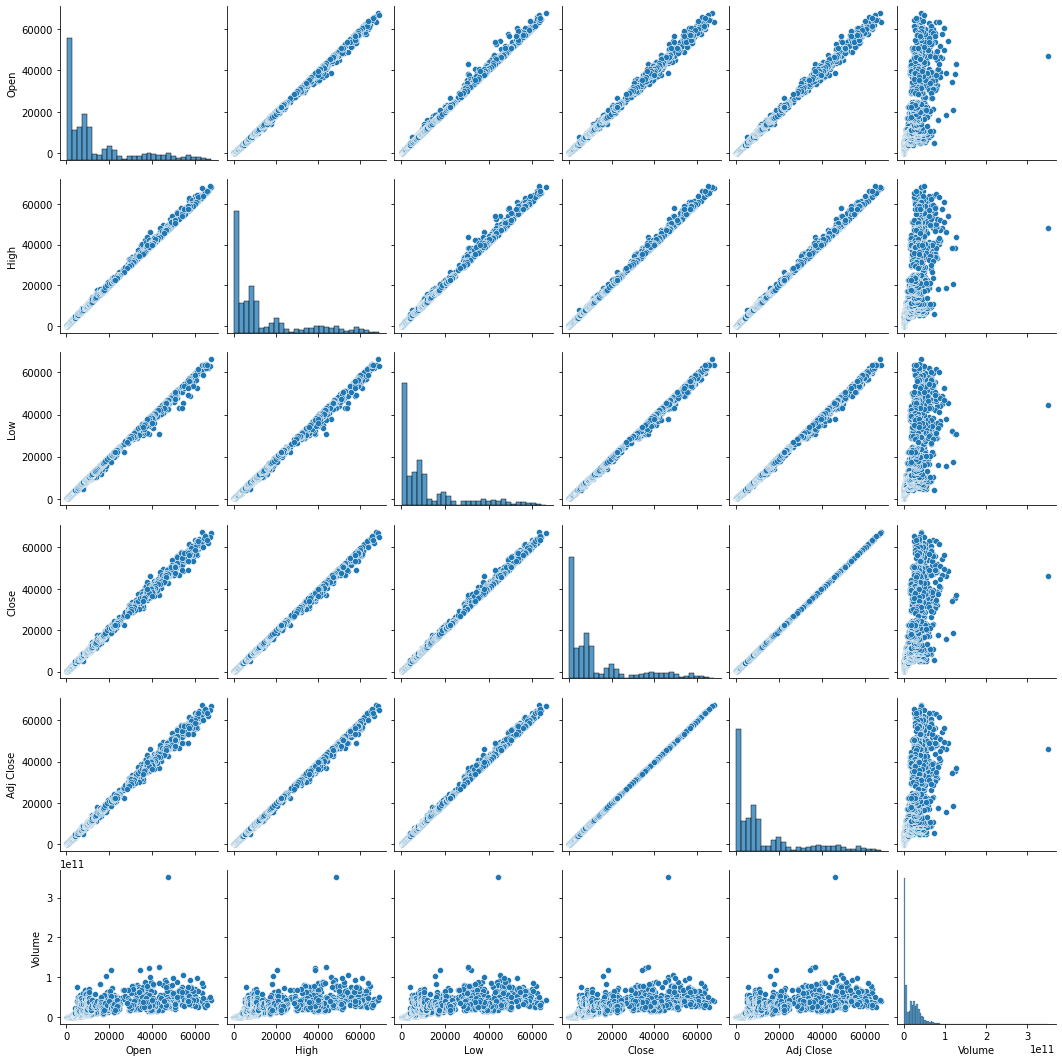

In [ ]:
sns.pairplot(df)

Видна корреляции и выброс у Volume. У Open и Close разброс в обе стороны. У Low со всеми признаками разброс идет вниз. У High со всеми признаками разброс идет вверх.

#### *OHLC*

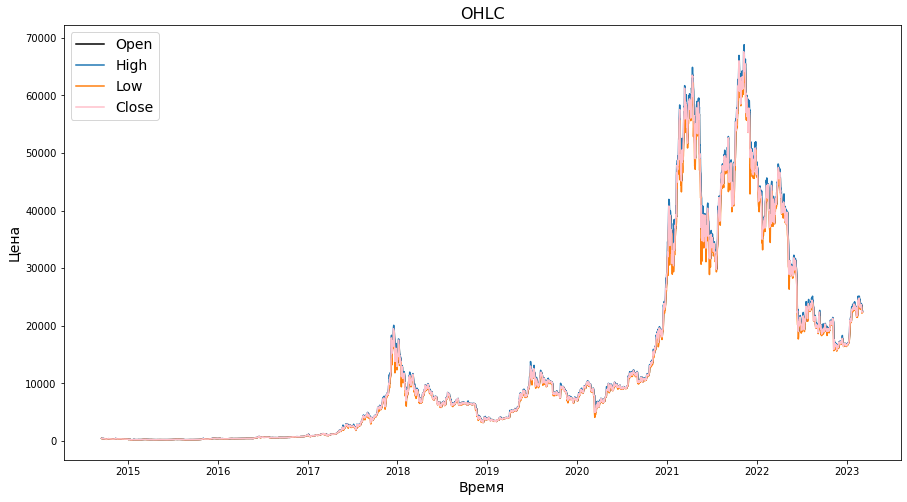

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['Open'], label = 'Open', color='black')
plt.plot(df['High'], label = 'High')
plt.plot(df['Low'], label = 'Low')
plt.plot(df['Close'], label = 'Close', color='pink')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Время', fontsize = 14)
plt.ylabel('Цена', fontsize = 14)
plt.title('OHLC', fontsize = 16)

plt.show()

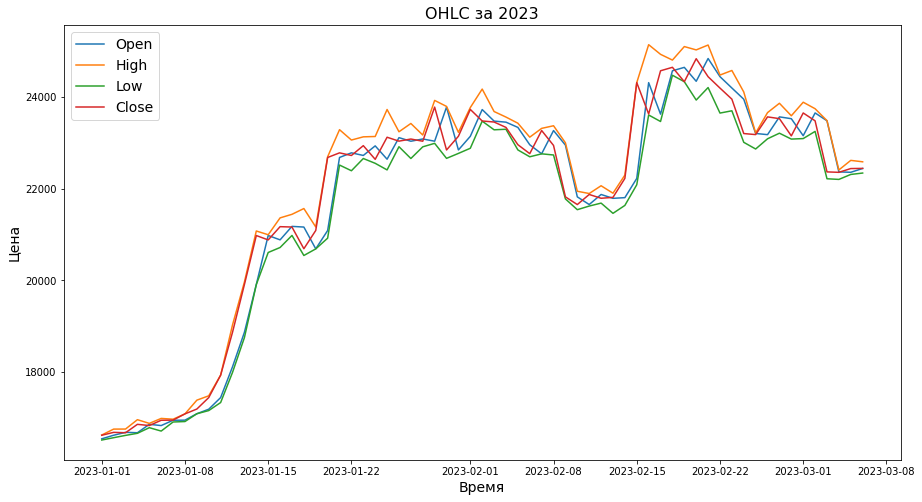

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['2023-01-01':]['Open'], label = 'Open')
plt.plot(df['2023-01-01':]['High'], label = 'High')
plt.plot(df['2023-01-01':]['Low'], label = 'Low')
plt.plot(df['2023-01-01':]['Close'], label = 'Close')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Время', fontsize = 14)
plt.ylabel('Цена', fontsize = 14)
plt.title('OHLC за 2023', fontsize = 16)

plt.show()

Графики почти полностью перекрывают друг друга, хотя как и предполагалось High чуть выше всех остальных, Low чуть ниже. Паттерн у всех одинаковый

Также можно заметить, что есть периоды, когда Open и Close практически полностью совпадают c Low или High, как, например, в начале.

#### *Close and Adj Close*

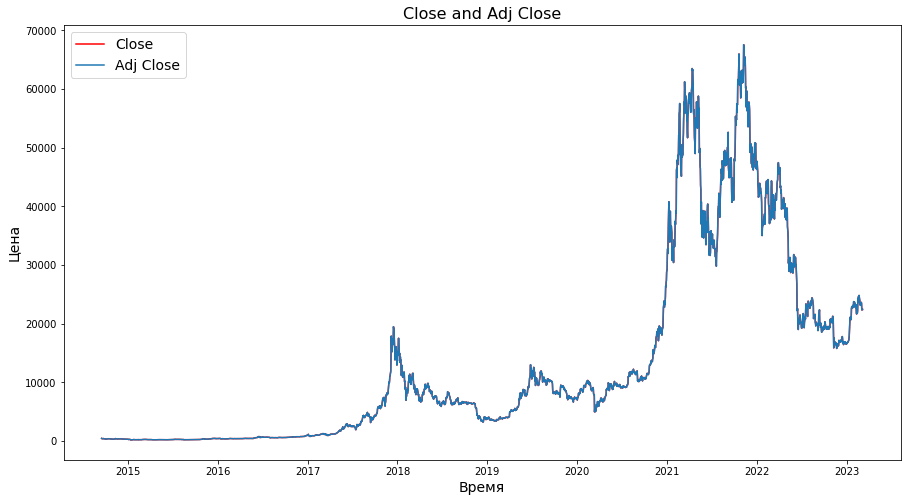

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['Close'], label = 'Close', color='red')
plt.plot(df['Adj Close'], label = 'Adj Close')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Время', fontsize = 14)
plt.ylabel('Цена', fontsize = 14)
plt.title('Close and Adj Close', fontsize = 16)

plt.show()

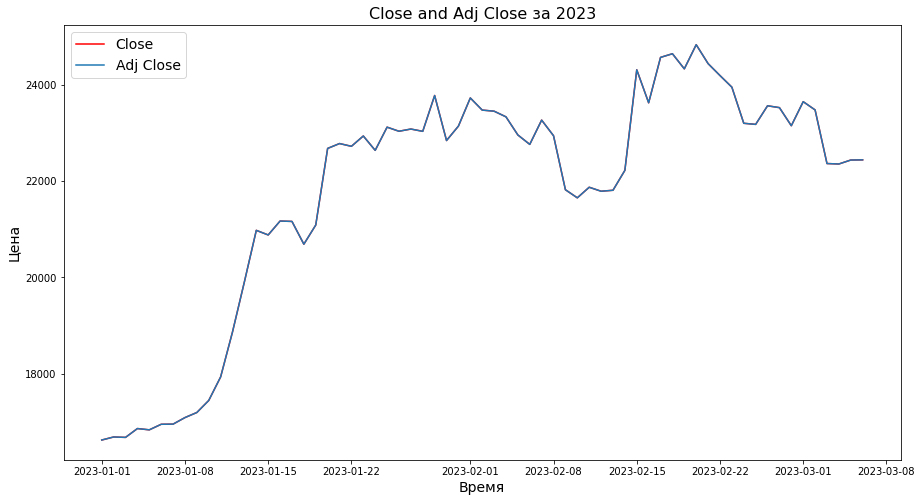

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['2023-01-01':]['Close'], label = 'Close', color='red')
plt.plot(df['2023-01-01':]['Adj Close'], label = 'Adj Close')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Время', fontsize = 14)
plt.ylabel('Цена', fontsize = 14)
plt.title('Close and Adj Close за 2023', fontsize = 16)

plt.show()

Close и Adj Close практически полностью перекрывают друг друга. Даже может имеет смысл удалить один из признаков

#### *Volume*

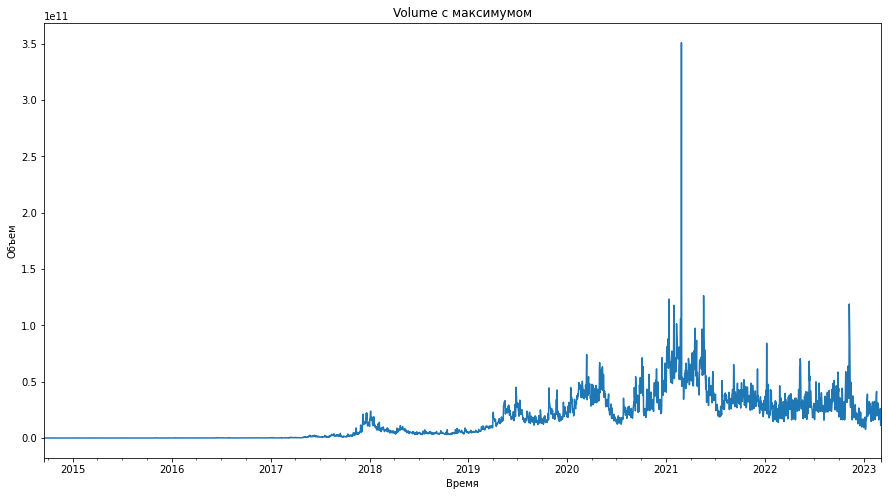

In [ ]:
ax = df['Volume'].plot(figsize = (15,8), legend = None)
ax.set(title='Volume с максимумом', xlabel = 'Время', ylabel = 'Объем');

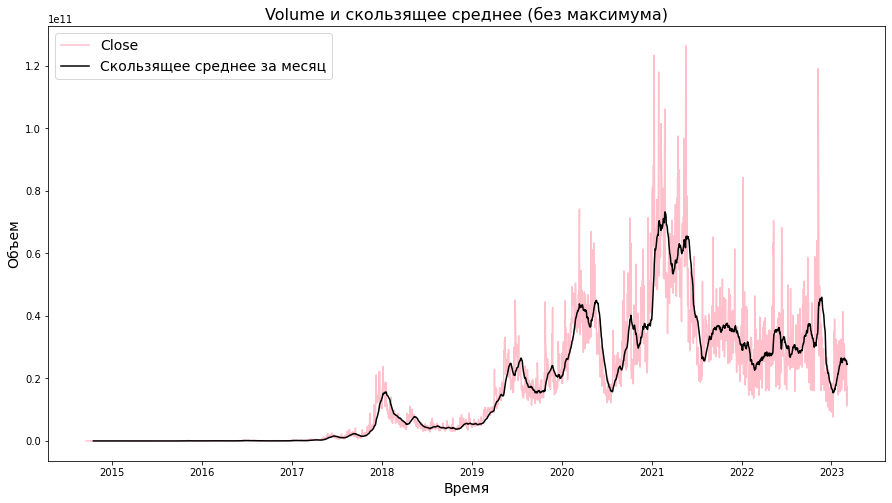

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df[df['Volume']!=350967941479]['Volume'], label = 'Close', color='pink')
plt.plot(df[df['Volume']!=350967941479]['Volume'].rolling(window = 30).mean(), label = 'Скользящее среднее за месяц', color='black')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Время', fontsize = 14)
plt.ylabel('Объем', fontsize = 14)
plt.title('Volume и скользящее среднее (без максимума)', fontsize = 16)

plt.show()

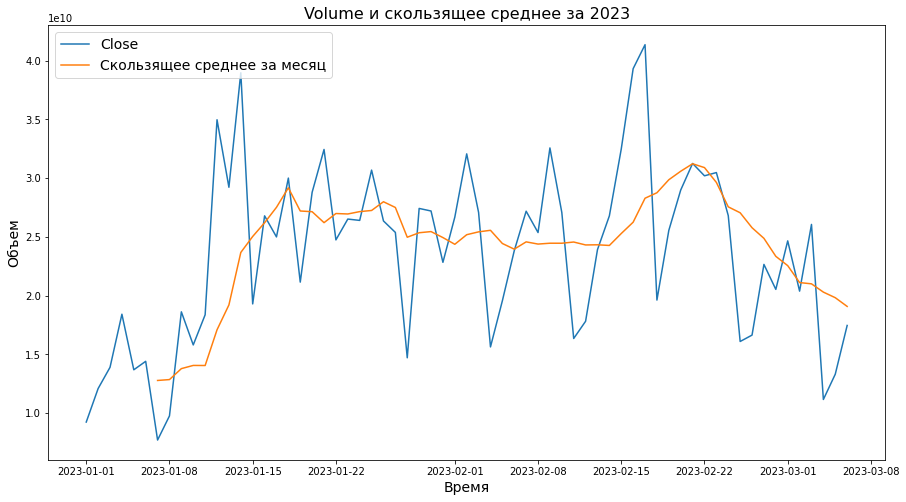

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['2023-01-01':]['Volume'], label = 'Close')
plt.plot(df['2023-01-01':]['Volume'].rolling(window = 7).mean(), label = 'Скользящее среднее за месяц')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.xlabel('Время', fontsize = 14)
plt.ylabel('Объем', fontsize = 14)
plt.title('Volume и скользящее среднее за 2023', fontsize = 16)

plt.show()

Между паттернами OHLC и Volume есть некоторые общие взлеты и падения, но в целом паттерны не совпадают

### Графики тренда, сезонности, случайных колебаний

* Тренд — долгосрочное изменение уровня ряда
* Сезонность предполагает циклические изменения уровня ряда с постоянным периодом
* Случайные колебания — непрогнозируемое случайное изменение ряда

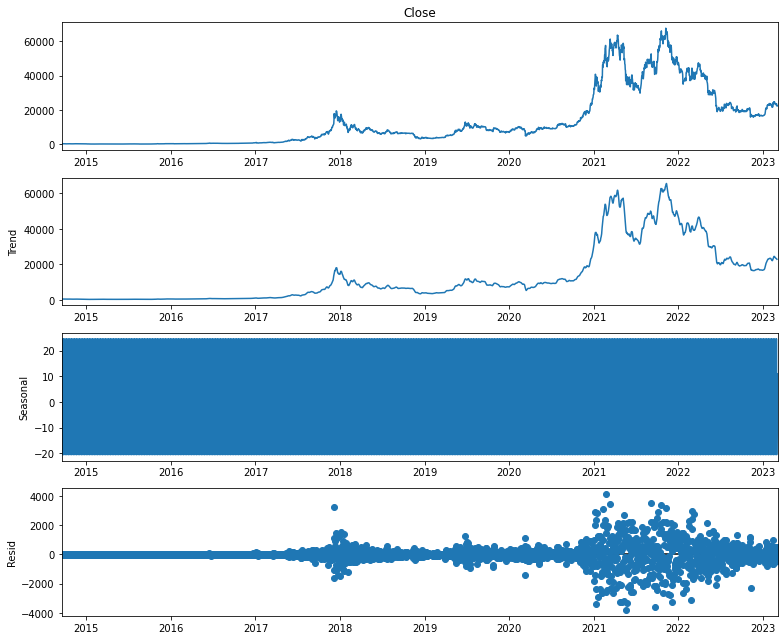

In [ ]:
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(df['Close'])
decompose.plot()

plt.show()

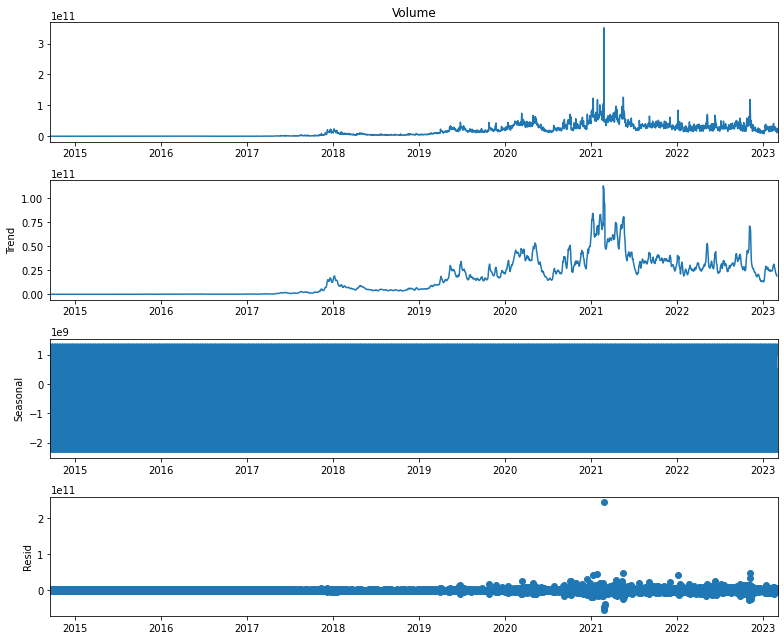

In [ ]:
decompose = seasonal_decompose(df['Volume'])
decompose.plot()

plt.show()

### Проверка на стационарность

Проведем тест Дики-Фуллера, альфа равна 0.05. Если p-value значительно выше этого значения, то нельзя отвергат гипотезу, что процесс нестационарный

In [ ]:
adf_test = adfuller(df['Close'])
print('p-value = ' + str(adf_test[1]))
adf_test[0]

p-value = 0.4763205753527942


-1.613153223585566

Для Close процесс нестационарный, то есть тренд и сезонность присутствуют (насчет сезонности я не уверен, так как не вижу ее на графике)




In [ ]:
adf_test = adfuller(df['Volume'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.23750122696222203


С Volume та же ситуация

### Автокорреляция

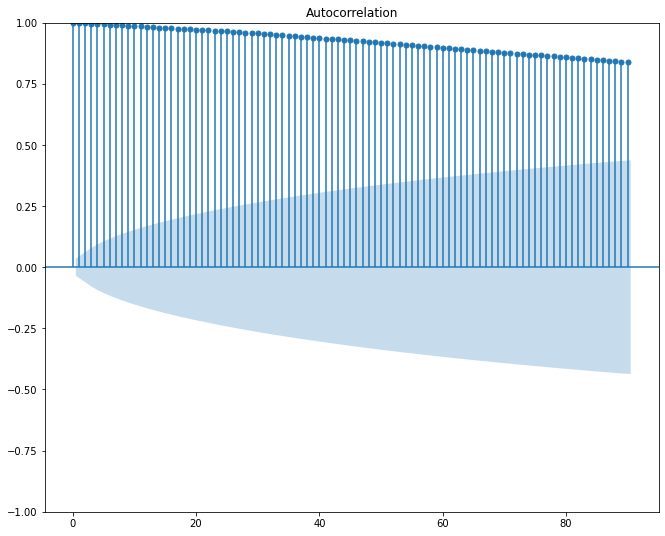

In [ ]:
plot_acf(df['Close'], lags=90)
plt.show()

То, что корреляция постоянно положительная говорит о наличии тренда. автокорреляция достаточно сильна и ее можно использовать при построении модели. мы видим, что со временем close меньше автокоррелирует, то есть прошлое меньше влиет на настоящее, чем раньше (?)

## Моделирование и построение прогноза

### Экспоненциальное сглаживание

> Может предсказывать только завтрашний день. Это бы имело хоть какой-то смысл, если бы точность была высокая, но увы это не так. 

In [ ]:
# цикл для поиска альфа, которое дает минмальное значение mape и минимальную разницу между предсказаным значением и настоящим
min_mape = 1000000
min_predict = 1000000
for alpha in np.arange(0.0, 1.0, 0.05):
  exp_smoothing = [df['Close'][0]]

  for i in range(1, len(df['Close'])):
    exp_smoothing.append(alpha * df['Close'][i] + (1 - alpha) * exp_smoothing[i - 1])
  
  tmp_mape = mean_absolute_percentage_error(df['Close'][1:], exp_smoothing[:-1])
  if tmp_mape < min_mape:
    df['Exp_smoothing_mape']=exp_smoothing
    min_mape = tmp_mape
    alpha_mape = alpha
  tmp_predict = abs(22219.77 - exp_smoothing[-1])
  if tmp_predict < min_predict:
    df['Exp_smoothing_predict']=exp_smoothing
    min_predict = tmp_predict
    alpha_predict = alpha
((min_mape, min_predict), (alpha_mape, alpha_predict))

((0.025127996763377368, 217.18035868509833), (0.9500000000000001, 0.8))

В первой скобке минмальное значение mape, и минимальное значение разницы между предсказаным значением и настоящим при разных альфах. В второй соотвествующие альфа.

In [ ]:
# добовляем завтрашний день в виде строки NaN
last_date = df.iloc[[-1]].index
last_date = last_date + timedelta(days = 1)
df = df.append(pd.DataFrame(index = last_date))

# сдвигаем столбцы с экспоненциальными сглаживаниями на один день
df['Exp_smoothing_mape'] = df['Exp_smoothing_mape'].shift(1)
df['Exp_smoothing_predict'] = df['Exp_smoothing_predict'].shift(1)

df

,Open,High,Low,Close,Adj Close,Volume,Exp_smoothing_mape,Exp_smoothing_predict
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07,457.334015,457.334015
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07,426.084703,431.018805
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07,396.360426,402.040553
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07,408.276814,407.531304
...,...,...,...,...,...,...,...,...
2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,22362.679688,2.606240e+10,23482.820063,23492.669546
2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,1.116601e+10,22418.686707,22588.677660
2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,22435.513672,1.331700e+10,22356.616464,22400.415219


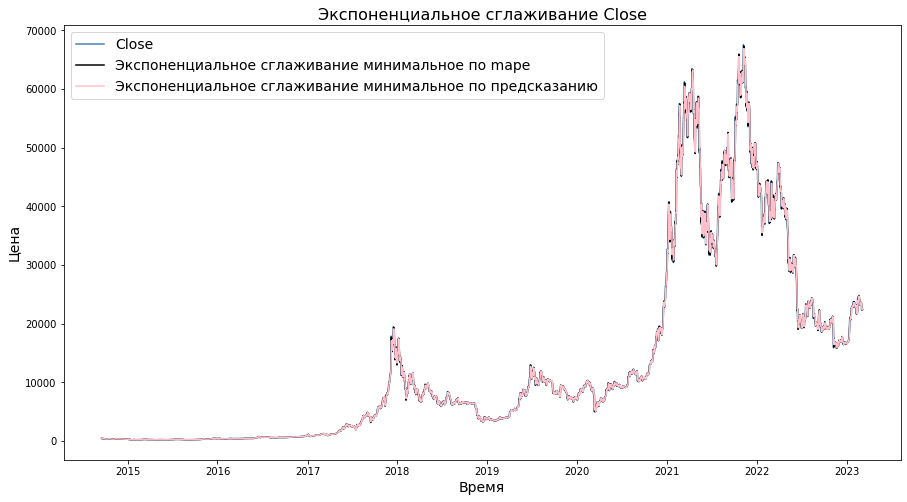

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['Close'], label = 'Close', color = 'steelblue')
plt.plot(df['Exp_smoothing_mape'], label = 'Экспоненциальное сглаживание минимальное по mape', color = 'black')
plt.plot(df['Exp_smoothing_predict'], label = 'Экспоненциальное сглаживание минимальное по предсказанию', color = 'pink')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.ylabel('Цена', fontsize = 14)
plt.xlabel('Время', fontsize = 14)
plt.title('Экспоненциальное сглаживание Close', fontsize = 16)

plt.show()

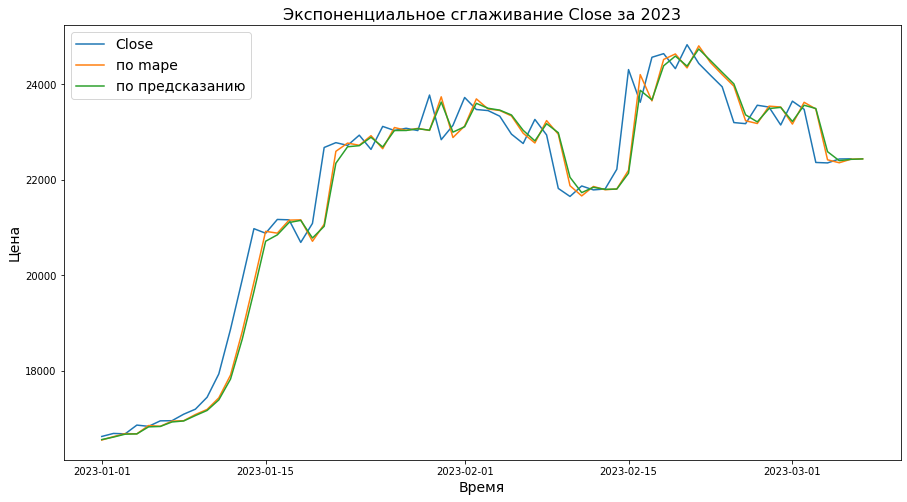

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['2023-01-01':]['Close'], label = 'Close')
plt.plot(df['2023-01-01':]['Exp_smoothing_mape'], label = 'по mape')
plt.plot(df['2023-01-01':]['Exp_smoothing_predict'], label = 'по предсказанию')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.ylabel('Цена', fontsize = 14)
plt.xlabel('Время', fontsize = 14)
plt.title('Экспоненциальное сглаживание Close за 2023', fontsize = 16)

plt.show()

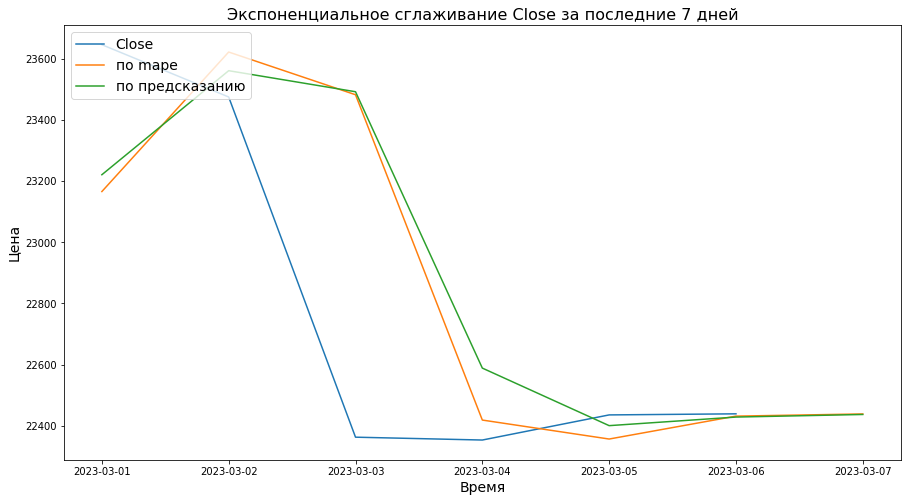

In [ ]:
plt.figure(figsize = (15,8))

plt.plot(df['2023-03-01':]['Close'], label = 'Close')
plt.plot(df['2023-03-01':]['Exp_smoothing_mape'], label = 'по mape')
plt.plot(df['2023-03-01':]['Exp_smoothing_predict'], label = 'по предсказанию')

plt.legend(title = '', loc = 'upper left', fontsize = 14)

plt.ylabel('Цена', fontsize = 14)
plt.xlabel('Время', fontsize = 14)
plt.title('Экспоненциальное сглаживание Close за последние 7 дней', fontsize = 16)

plt.show()

### Модель SARIMAX

In [ ]:
# обучающая выборка будет включать данные до декабря 1959 года включительно
train = df[:'2022-08-31']['Close']
 
# тестовая выборка начнется с января 1960 года (по сути, один год)
test = df['2022-09-01':]['Close']

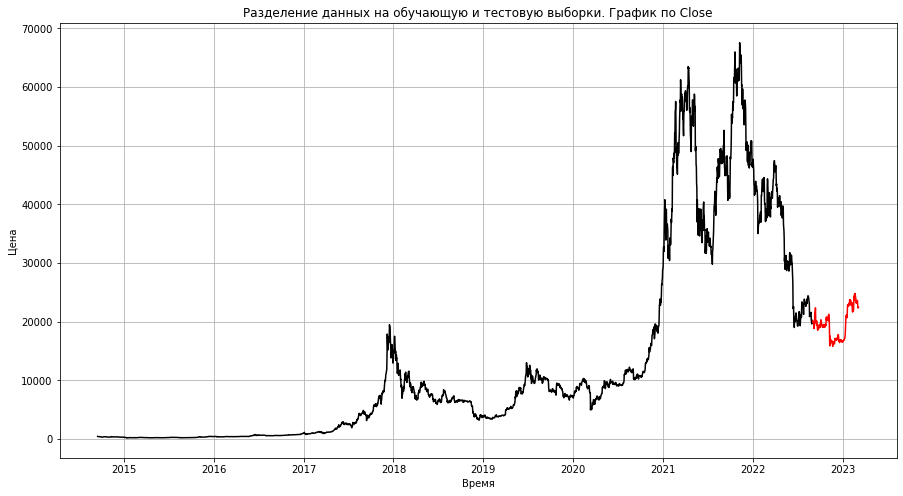

In [ ]:
# выведем эти данные на графике
plt.figure(figsize = (15,8))

plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных на обучающую и тестовую выборки. График по Close')
plt.ylabel('Цена')
plt.xlabel('Время')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)

# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

# создадим объект этой модели
model = SARIMAX(train, 
                exog=df[:'2022-08-31']['Volume'],
                order = (3, 0, 0), 
                seasonal_order = (0, 1, 0, 12))

# применим метод fit
result = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 2
  
# применим метод predict
predictions = result.predict(start, end, exog=df['2022-09-01':'2023-03-06']['Volume'])
predictions

2022-09-01    20264.146560
2022-09-02    20725.143439
2022-09-03    20829.751094
2022-09-04    21003.884352
2022-09-05    20882.924100
                  ...     
2023-03-02    20559.623679
2023-03-03    20711.962217
2023-03-04    20845.432357
2023-03-05    21086.789704
2023-03-06    19901.398477
Freq: D, Name: predicted_mean, Length: 187, dtype: float64

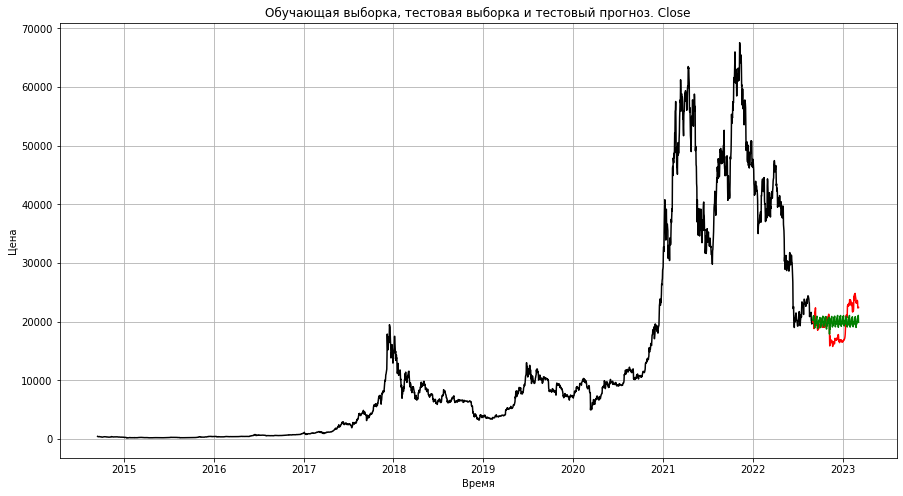

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize = (15,8))

plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')

# заголовок и подписи к осям
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз. Close')
plt.ylabel('Цена')
plt.xlabel('Время')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
(mean_absolute_percentage_error(test[:-1], predictions), r2_score(test[:-1], predictions))

(0.11713111170357685, -0.08752621438452968)

In [ ]:
# прогнозный период начнется с конца имеющихся данных
start = len(df)

# и закончится 36 месяцев спустя
end = (len(df) - 1) + 365

# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)

# посмотрим на весь 1963 год
forecast[-12:]

ValueError: ignored

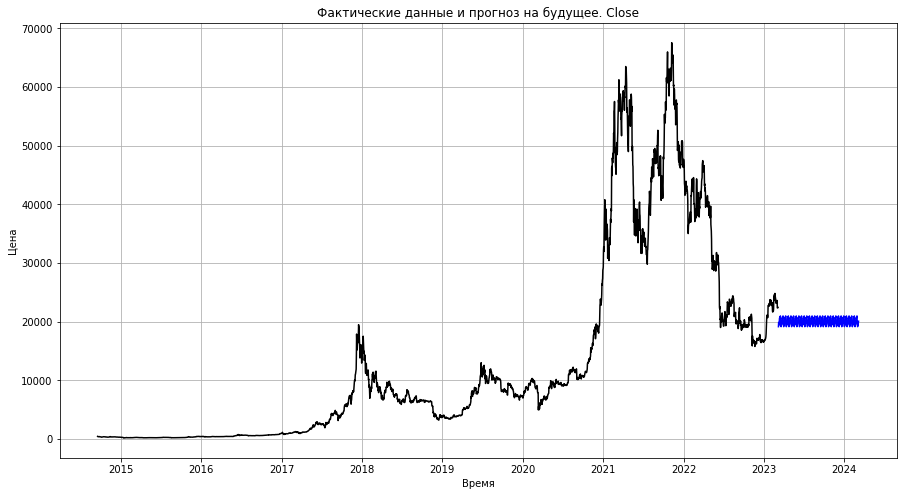

In [ ]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.figure(figsize = (15,8))


plt.plot(df['Close'], color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее. Close')
plt.ylabel('Цена')
plt.xlabel('Время')

# добавим сетку
plt.grid()

plt.show()

✍

In [ ]:
diff = list()
for i in range(1, len(df['Close'])):
 value = df['Close'][i] - df['Close'][i - 1]
 diff.append(value)
# line plot

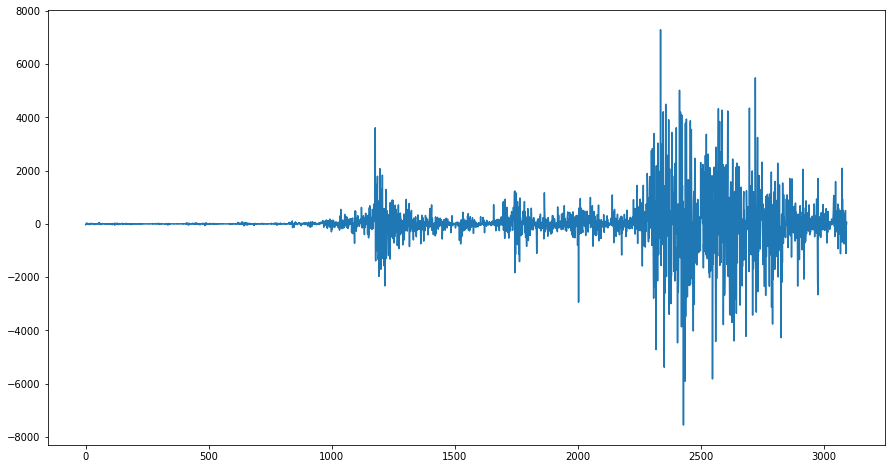

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(diff)
plt.show()